In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geopandas
!pip install pyshp

# os
import os 
import random
import pickle
import zipfile
import math

# pandas, geopandas
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
import shapefile
from pyproj import CRS, Transformer

# path

import re
import pathlib
from glob import glob
from pathlib import Path

# numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# models (ensemble)
!pip install lightgbm
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 16.7 MB 32.3 MB/s 
     |████████████████████████████████| 6.3 MB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
CFG = {
    'SEED': 41
}

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

b_path = Path('bug_final') 
s_path = Path('qgis/세이프파일')
bd_path = Path('qgis/버그거리행렬')
sd_path = Path('qgis/세이프거리행렬')
r_path = Path('qgis/임도망도중심점')

#select_cols = ['LATITUDE', 'LONGITUDE', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'STATION_ID']

with open(str(path / 'models' / 'kmeans'), 'rb') as f:
  kmeans = pickle.load(f)

with open(str(path / 'models' / 'kmeans_label'), 'rb') as f:
  kmeans_label = pickle.load(f)

pd.set_option('display.float_format', '{:,.5f}'.format)

# DATABASE 전처리

In [5]:
# 절차 진행 함수

class DataLoader():

  def __init__(self, path):
    self.path = path
    
    try:
      self.data = pd.read_csv(path)
    except:
      try:
        self.data = pd.read_csv(path, encoding='cp949')
      except:
        try:
          with open(path, 'rb') as f:
            self.data = pickle.load(f)
        except:
          raise ValueError("Error")
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data.loc[idx]

# loader
def loader(string):

  data_b = DataLoader(str(path / b_path / f'{string}_bug.csv')).data
  data_s = DataLoader(str(path / s_path / f'{string}_safe.csv')).data

  data_bd = DataLoader(str(path / bd_path / f'{string}_bug_distance.csv')).data
  data_sd = DataLoader(str(path / sd_path / f'{string}_safe_distance.csv')).data
  data_r = DataLoader(str(path / r_path / f'{string}_road_center.csv')).data

  # data_b = data_b[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]
  # data_s = data_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD']]

  data_b = pd.concat([data_b, data_bd], axis=1)
  data_s = pd.concat([data_s, data_sd], axis=1)

  return data_b, data_s, data_bd, data_sd, data_r


# 좌표 변환
def extract_lat_log(local_df):
  p = re.compile(r'[a-zA-Z(())]')

  lat_log = []
  cnt = 0
  for row in local_df.itertuples():
    if cnt == 0:
      print(row)
    lat, log = map(float, re.sub(p, '', row[1]).strip().split(' '))
    if cnt == 0:
      print(lat, log)

    lat_log.append([lat, log])

    cnt += 1
  
  return np.array(lat_log)

def run_prob(data_s, string, idx=0):
  data_safe_coord = extract_lat_log(data_s)

  data_s['LATITUDE'] = data_safe_coord[:, 0]
  data_s['LONGITUDE'] = data_safe_coord[:, 1]

  #데이터 저장하는 구간
  if idx == 1:
    data_s.to_csv(str(path / 'safe' / f'{string}_safe.csv'.split('/')[-1]), index=False)

  return data_s

def road_run_prob(data_r, string):
  data_safe_coord = extract_lat_log(data_r)

  data_r['LATITUDE'] = data_safe_coord[:, 0]
  data_r['LONGITUDE'] = data_safe_coord[:, 1]

  #data_r = data_r.drop(['WKT'], axis=1)

  #데이터 저장하는 구간
  with open(str(path / 'dbdata' / str(string + '_road_db')), 'wb') as f:
    pickle.dump(data_r, f, pickle.HIGHEST_PROTOCOL)

  return data_r

def make_kmeans_station(station, path):
    # 지점 클러스터링
  X = np.array(station[['STATION_ID','LATITUDE', 'LONGITUDE']])

  kmeans = KMeans(n_clusters=95, random_state=41).fit(X[:, 1:3])

  X_label = kmeans.labels_[:, np.newaxis]

  label = np.concatenate([X, X_label], axis=1)

  label_df = pd.DataFrame(data=label, columns=['STATION_ID', 'LATITUDE', 'LONGITUDE', 'LABEL'])
  
  label_df[['STATION_ID','LABEL']] = label_df[['STATION_ID', 'LABEL']].astype(int) 
  sns.scatterplot(data=label_df, x='LATITUDE', y='LONGITUDE', hue='LABEL')

  label_dict = {}

  for row in label_df.itertuples():
    label_dict[row[4]] = row[1]

  with open(str(path / 'models' / 'kmeans'), 'wb') as f:
    pickle.dump(kmeans, f, pickle.HIGHEST_PROTOCOL)

  with open(str(path / 'models' / 'kmeans_label'), 'wb') as f:
    pickle.dump(label_dict, f, pickle.HIGHEST_PROTOCOL)
  
  return kmeans, label_dict


def apply_kmeans_station(kmeans, label_dict, gis_df, string, save_sec_path):

  if 'STATION_ID' in gis_df.columns:
    gis_df = gis_df.drop(['STATION_ID'], axis=1)
  
  pred = gis_df[['LATITUDE', 'LONGITUDE']]
  pred_np = pred.to_numpy()

  pred_lat = pred_np[:, 0]
  pred_log = pred_np[:, 1]

  pred_cls_label = kmeans.predict(pred_np)

  pred_id = pd.DataFrame(data=[label_dict[row] for row in pred_cls_label], columns=['STATION_ID'])

  gis_df = pd.concat([gis_df, pred_id], axis=1)

  gis_df.to_csv(str(path / save_sec_path / f'{string}_safe.csv'.split('/')[-1]), index=False)

  sns.scatterplot(data=gis_df, x='LATITUDE', y='LONGITUDE', hue='STATION_ID', palette="Paired")

  return gis_df

# preprocessing_bug
def preprocessing_bug(data, string):

  wkt_col_list = ['WKT1', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
                'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
                'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
                'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

  col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
            'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
            'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
            'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

  data = data[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
                 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
                 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
                 'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

  data = data.fillna(-1)

  data.columns = wkt_col_list


  for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
    try:
      data[c] = data[c].astype(int)
    except:
      print(c)
      pass
      
  data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
  data = data.reset_index(drop=True)
  data = data.reset_index()
  data = data.drop(['WKT1'], axis=1)
  data.columns = col_list

  with open(str(path / 'dbdata' / str(string + '_bug_db')), 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

  return data

# preprocessing_safe
def preprocessing_safe(data, string):

  wkt_col_list = ['WKT1', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
                  'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
                  'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

  col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
            'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
            'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

  data = data[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
            'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
            'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

  data = data.fillna(-1)
  data.columns = wkt_col_list

  
  for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
    try:
      data[c] = data[c].astype(int)
    except:
      print(c)
      pass
  
  data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
  data = data.reset_index(drop=True)
  data = data.reset_index()
  data = data.drop(['WKT1'], axis=1)
  data.columns = col_list

  with open(str(path / 'dbdata' / str(string + '_safe_db')), 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


  return data

def run(local_string):
  data_b, data_s, data_bd, data_sd, data_r = loader(local_string)
  print(1)
  data_b = run_prob(data_b, local_string)
  print(2)
  data_s = run_prob(data_s, local_string, idx=1)
  print(3)
  data_r = road_run_prob(data_r, local_string)
  print(4)
  data_b = apply_kmeans_station(kmeans, kmeans_label, data_b, local_string, 'bug_re')
  print(5)
  data_s = apply_kmeans_station(kmeans, kmeans_label, data_s, local_string, 'safe_re')
  print(6)
  data_b = preprocessing_bug(data_b, local_string)
  print(7)
  data_s = preprocessing_safe(data_s, local_string)
  print(8)

  return data_b, data_s, data_r

# 경남

1
Pandas(Index=0, WKT='POINT (1088724.3914 1738287.1668)', OCCRR_NO=9754816.0, DBHIS_CD=2888.0, MNAGN_CD=5410000, ARA_XCRD=334051.0, ARA_YCRD=338749.0, NTN_SPOT='라마88723828', LGDNG_CD=4874032024, IFTTR_TPCD=1.0, EXMNN_OTST=20170119, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=3360.0, LAST_UPUSR=nan, LAST_UPDT=nan, layer='TB_DPMS_PWLDS_OCCRR_M_48-1', path='C:/Users/user/Downloads/경남 버그/FRT000202_48/TB_DPMS_PWLDS_OCCRR_M_48-1.shp', STORUNST=1, FROR_CD=2, FRTP_CD=3, KOFTR_GROU=77, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=10.0, LDMARK_STN='J12377', MAP_LABEL='NMM-24C', ETC_PCMTT=nan, layer_2='TB_FGDI_FS_IM5000_48740', path_2='C:/Users/user/Downloads/경남 임상도/FRT001003_48740/TB_FGDI_FS_IM5000_48740.shp', _31='POINT (1088724.3914 1738287.1668)', InputID='POINT (1088724.3914 1738287.1668)', MEAN=64195.1147788721, STDDEV=21974.9944640189, MIN=2644.14048884185, MAX=114130.079553399)
1088724.3914 1738287.1668
2
Pandas(Index=0, WKT='POINT (1107459.56440537 1694123.75149745)', STORUNST=0, FROR_

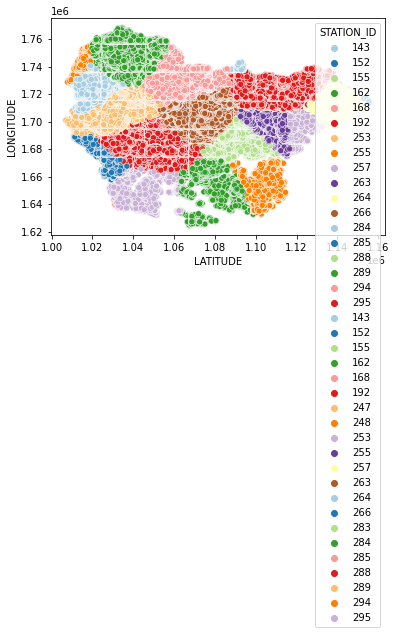

In [ ]:
local_string = 'gyeongnam'

data_b, data_s, data_r = run(local_string)

In [ ]:
name_string = 'gyeongnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1107459.56440537 1694123.75149745),0,0,0,91,-1,-1,-1,-1,J00091,S,"60,333.89018","26,161.28650","4,241.45157","106,249.35915","1,107,459.56441","1,694,123.75150",255
1,1,POINT (1110672.08473552 1695523.97916679),0,0,0,91,-1,-1,-1,-1,J00091,S,"62,155.16584","27,177.93089",895.25654,"108,432.43222","1,110,672.08474","1,695,523.97917",255
2,2,POINT (1106832.94898902 1695704.44484722),0,0,0,91,-1,-1,-1,-1,J00091,S,"59,977.16385","25,721.59151","4,737.40246","104,946.59763","1,106,832.94899","1,695,704.44485",255


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1088724.3914 1738287.1668),9754816,2888,5410000,"334,051.00000","338,749.00000",20170119,4874032024,1,...,10,J12377,NMM-24C,"64,195.11478","21,974.99446","2,644.14049","114,130.07955","1,088,724.39140","1,738,287.16680",143
1,1,POINT (1088725.4722 1738303.1532),9754817,2888,5410000,"334,052.00000","338,765.00000",20170119,4874032024,1,...,10,J12377,NMM-24C,"64,204.70877","21,977.00300","2,659.76974","114,144.60911","1,088,725.47220","1,738,303.15320",143
2,2,POINT (1088733.4577 1738301.1136),9754818,2888,5410000,"334,060.00000","338,763.00000",20170119,4874032024,1,...,10,J12377,NMM-24C,"64,206.06433","21,978.26560","2,656.52946","114,146.67484","1,088,733.45770","1,738,301.11360",143


# 경기

1
Pandas(Index=0, WKT='POINT (972686.8123 1990203.5553)', OCCRR_NO=12358797.0, DBHIS_CD=6221.0, MNAGN_CD=5600000, ARA_XCRD=216645.0, ARA_YCRD=590171.0, NTN_SPOT='다사72689020', LGDNG_CD=4165034021, IFTTR_TPCD=1.0, EXMNN_OTST=20170930, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=484.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=1, FRTP_CD=1, KOFTR_GROU=13, DMCLS_CD=3.0, AGCLS_CD=5.0, DNST_CD='C', HEIGHT=18.0, LDMARK_STN='J11113', MAP_LABEL='ALL-35C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_41650', path='C:/Users/user/Downloads/경기도 임상도/FRT001003_41650/TB_FGDI_FS_IM5000_41650.shp', _29='POINT (972686.8123 1990203.5553)', InputID=12358797.0, MEAN=37387.1052514303, STDDEV=23805.7931947157, MIN=807.44440533478, MAX=111729.336247698)
972686.8123 1990203.5553
2
Pandas(Index=0, WKT='POINT (958638.991597152 1922188.32429956)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, layer='TB_FGDI

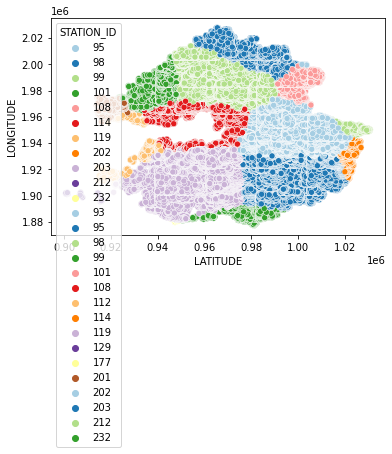

In [ ]:
local_string = 'gyeonggi'

data_b, data_s, data_r = run(local_string)

# 인천

Pandas(Index=0, WKT='POINT (926080.878 1940649.8788)', OCCRR_NO=13948993.0, DBHIS_CD=9803.0, MNAGN_CD=1400443, ARA_XCRD=170287, ARA_YCRD=540351, NTN_SPOT='�ٻ�26084064', LGDNG_CD=2817710400, IFTTR_TPCD=nan, EXMNN_OTST=20190409, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=1.0, LAST_UPUSR=nan, LAST_UPDT=nan)
926080.878 1940649.8788
2
Pandas(Index=0, WKT='POINT (911931.510471148 1947451.85592637)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_28110', path='/home/koseyun/다운로드/인천/임상도/FRT001003_28110/TB_FGDI_FS_IM5000_28110.shp')
911931.510471148 1947451.85592637
3
5
STORUNST
FROR_CD
FRTP_CD
KOFTR_GROU
DMCLS_CD
AGCLS_CD
HEIGHT


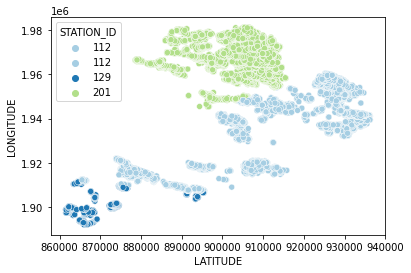

In [ ]:
local_string = 'incheon'

data_b = DataLoader(str(path / b_path / f'{local_string}_bug.csv')).data
data_s = DataLoader(str(path / s_path / f'{local_string}_safe.csv')).data

data_bd = DataLoader(str(path / bd_path / f'{local_string}_bug_distance.csv')).data
data_sd = DataLoader(str(path / sd_path / f'{local_string}_safe_distance.csv')).data
data_r = DataLoader(str(path / r_path / f'{local_string}_road_center.csv')).data

data_b = run_prob(data_b, local_string)
print(2)
data_s = run_prob(data_s, local_string, idx=1)
print(3)

data_b = apply_kmeans_station(kmeans, kmeans_label, data_b, local_string, 'bug_re')
print(5)
data_s = apply_kmeans_station(kmeans, kmeans_label, data_s, local_string, 'safe_re')


col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'LGDNG_CD', 'EXMNN_OTST', \
            'LATITUDE', 'LONGITUDE', 'STATION_ID']


data = data_b[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'LGDNG_CD', 'EXMNN_OTST', \
            'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)


for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass
    
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_bug_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', 'ETC_PCMTT', 'layer', 'path', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', 'ETC_PCMTT', 'layer', 'path', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)

for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass

data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_safe_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# 울산

1
Pandas(Index=0, WKT='POINT (1161256.17 1710136.6164)', OCCRR_NO=2191988.0, DBHIS_CD=323.0, MNAGN_CD=3400000, ARA_XCRD=406765.6853826074, ARA_YCRD=310950.9210182252, NTN_SPOT='마마61251013', LGDNG_CD=2671025333, IFTTR_TPCD=2.0, EXMNN_OTST=20141129, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=0.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=15, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=16.0, LDMARK_STN='J12115', MAP_LABEL='NPT-24C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_31710', path='C:/Users/user/Downloads/울산 임상도/FRT001003_31710/TB_FGDI_FS_IM5000_31710.shp', _29='POINT (1161256.17 1710136.6164)', InputID=2191988.0, MEAN=21422.2404471488, STDDEV=13047.8996338002, MIN=1219.05797989055, MAX=39606.4690789438)
1161256.17 1710136.6164
2
Pandas(Index=0, WKT='POINT (1163209.27077644 1731396.52508053)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, laye

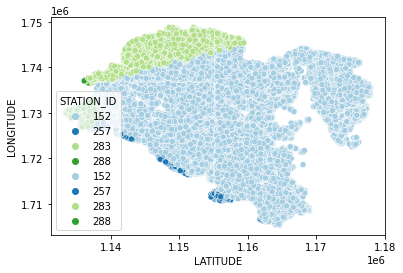

In [ ]:
local_string = 'ulsan'

data_b, data_sd, data_r = run(local_string)

In [ ]:
name_string = 'ulsan'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1163209.27077644 1731396.52508053),0,0,0,91,-1,-1,-1,-1,J00091,S,"20,103.95381","5,485.14414","5,964.77571","26,509.34090","1,163,209.27078","1,731,396.52508",152
1,1,POINT (1164848.39709559 1732023.40659225),0,0,0,91,-1,-1,-1,-1,J00091,S,"21,149.51193","6,132.41383","5,713.40279","27,934.84888","1,164,848.39710","1,732,023.40659",152
2,2,POINT (1164797.21995081 1732072.57158848),0,0,0,91,-1,-1,-1,-1,J00091,S,"21,131.31539","6,121.60389","5,649.05827","27,873.50769","1,164,797.21995","1,732,072.57159",152


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1161256.17 1710136.6164),2191988,323,3400000,"406,765.68538","310,950.92102",20141129,2671025333,1,...,16,J12115,NPT-24C,"21,422.24045","13,047.89963","1,219.05798","39,606.46908","1,161,256.17000","1,710,136.61640",152
1,1,POINT (1161164.6299 1710214.9715),2195354,360,3400000,"406,673.69447","311,028.85955",20150114,2671025333,1,...,16,J12115,NPT-24C,"21,317.47748","13,047.50564","1,201.10639","39,496.50278","1,161,164.62990","1,710,214.97150",152
2,2,POINT (1161212.3691 1710181.9665),2190001,323,3400000,"406,721.62898","310,996.07647",20141111,2671025333,1,...,16,J12115,NPT-24C,"21,366.76765","13,046.64858","1,202.33657","39,546.73896","1,161,212.36910","1,710,181.96650",152


# 강원

1
Pandas(Index=0, WKT='POINT (1007045.7684 1995727.9352)', OCCRR_NO=16689637.0, DBHIS_CD=1001.0, MNAGN_CD='DP64201', ARA_XCRD=250988.0, ARA_YCRD=595882.0, NTN_SPOT='라사070495', LGDNG_CD=4182035023.0, IFTTR_TPCD=nan, EXMNN_OTST=20200401, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=5.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=1, FRTP_CD=1, KOFTR_GROU=12, DMCLS_CD=3.0, AGCLS_CD=6.0, DNST_CD='C', HEIGHT=22.0, LDMARK_STN='J11112', MAP_LABEL='APK-36C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_42110', path='C:/Users/user/Downloads/강원도 임상도/FRT001003_42110/TB_FGDI_FS_IM5000_42110.shp', _29='POINT (1007045.7684 1995727.9352)', InputID=16689637.0, MEAN=nan, STDDEV=nan, MIN=nan, MAX=nan)
1007045.7684 1995727.9352
2
Pandas(Index=0, WKT='POINT (1003525.81264216 1971038.29366097)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=93, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00093', MAP_LABEL='C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_42110', path='C:/Users/user/Downloads

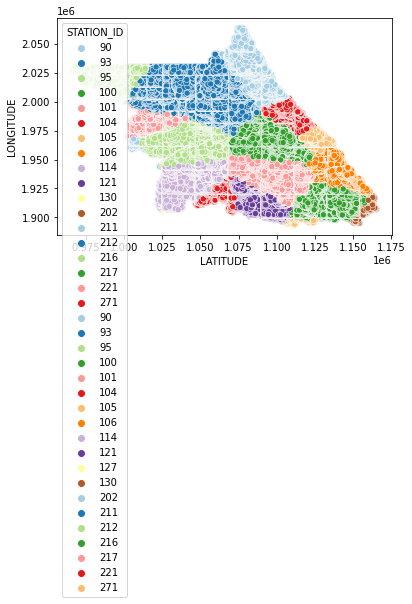

In [ ]:
local_string = 'gangwon'

data_b, data_s, data_r = run(local_string)

# 부산

1
Pandas(Index=0, WKT='POINT (1149590.8388 1695784.0444)', OCCRR_NO=11033856.0, DBHIS_CD=4302.0, MNAGN_CD=3330000, ARA_XCRD=395166.0, ARA_YCRD=296531.0, NTN_SPOT='마라49599578', LGDNG_CD=2635010100, IFTTR_TPCD=1.0, EXMNN_OTST=20171101, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=1.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=11, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=14.0, LDMARK_STN='J12111', MAP_LABEL='NPD-24C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_26350', path='C:/Users/user/Downloads/부산 임상도/FRT001003_26350/TB_FGDI_FS_IM5000_26350.shp', _29='POINT (1149590.8388 1695784.0444)', InputID=11033856.0, MEAN=14061.725906232, STDDEV=9247.12107479438, MIN=1686.29238228087, MAX=39259.2913026378)
1149590.8388 1695784.0444
2
Pandas(Index=0, WKT='POINT (1139276.06402984 1680202.04504123)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, LOCAL_CD=26110

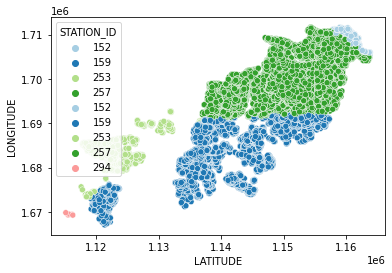

In [ ]:
busan_b, busan_s, busan_r = run('busan')

In [ ]:
name_string = 'busan'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1139276.06402984 1680202.04504123),0,0,0,91,-1,-1,-1,-1,J00091,S,"12,924.46464","7,892.79075","2,185.76091","27,723.57680","1,139,276.06403","1,680,202.04504",159
1,1,POINT (1139377.59004686 1680295.81746609),1,1,1,10,3,5,C,18,J11110,AEC-35C,"12,856.31053","7,881.16110","2,319.53879","27,599.63797","1,139,377.59005","1,680,295.81747",159
2,2,POINT (1139321.38913838 1680252.82013827),1,1,1,17,2,4,C,14,J11117,ACP-24C,"12,888.40814","7,887.64313","2,252.92714","27,659.90819","1,139,321.38914","1,680,252.82014",159


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1149590.8388 1695784.0444),11033856,4302,3330000,"395,166.00000","296,531.00000",20171101,2635010100,1,...,14,J12111,NPD-24C,"14,061.72591","9,247.12107","1,686.29238","39,259.29130","1,149,590.83880","1,695,784.04440",257
1,1,POINT (1149582.8889 1695793.0793),11033857,4302,3330000,"395,158.00000","296,540.00000",20171101,2635010100,1,...,14,J12111,NPD-24C,"14,062.02881","9,247.23903","1,683.31353","39,259.68728","1,149,582.88890","1,695,793.07930",257
2,2,POINT (1149506.3709 1695681.5299),11033858,4302,3330000,"395,082.00000","296,428.00000",20171101,2635010100,1,...,14,J12111,NPD-24C,"13,986.04708","9,204.93356","1,565.55530","39,127.52178","1,149,506.37090","1,695,681.52990",257


# 충북

1
Pandas(Index=0, WKT='POINT (1014135.2268 1785957.2784)', OCCRR_NO=10983468.0, DBHIS_CD=4096.0, MNAGN_CD='6430000', ARA_XCRD=259183.0, ARA_YCRD=386060.0, NTN_SPOT='라마14138595', LGDNG_CD=4374038000, IFTTR_TPCD=nan, EXMNN_OTST=20180314, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=2.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=11, DMCLS_CD=1.0, AGCLS_CD=3.0, DNST_CD='C', HEIGHT=12.0, LDMARK_STN='J12111', MAP_LABEL='NPD-13C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_43740', path='C:/Users/user/Downloads/충북 임상도/FRT001003_43740/TB_FGDI_FS_IM5000_43740.shp', _29='POINT (1014135.2268 1785957.2784)', InputID=10983468.0, MEAN=76441.579772914, STDDEV=36445.1946415077, MIN=3668.77908756661, MAX=141193.900373016)
1014135.2268 1785957.2784
2
Pandas(Index=0, WKT='POINT (998006.365848376 1831419.46404743)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91.0, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, LOCAL_CD=4

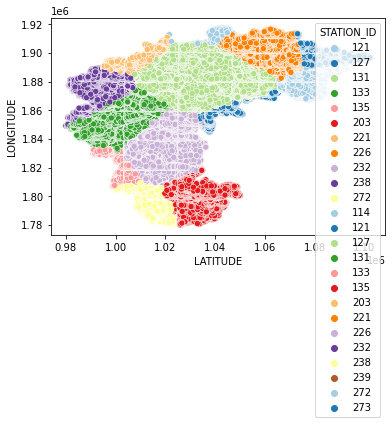

In [ ]:
chungbuk_b, chungbuk_s, chungbuk_r = run('chungbuk')

In [ ]:
name_string = 'chungbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (998006.365848376 1831419.46404743),0,0,0,91,-1,-1,-1,-1,J00091,S,"56,498.91130","33,117.12581","1,667.45168","121,570.94192","998,006.36585","1,831,419.46405",133
1,1,POINT (1003536.16697774 1833575.14427882),0,0,0,91,-1,-1,-1,-1,J00091,S,"52,157.75629","32,568.43212",504.95351,"115,773.90965","1,003,536.16698","1,833,575.14428",226
2,2,POINT (995960.781707831 1834858.27278853),0,0,0,91,-1,-1,-1,-1,J00091,S,"56,478.72688","32,221.00546","1,109.75934","121,445.95850","995,960.78171","1,834,858.27279",131


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1014135.2268 1785957.2784),10983468,4096,6430000,"259,183.00000","386,060.00000",20180314,4374038000,1,...,12,J12111,NPD-13C,"76,441.57977","36,445.19464","3,668.77909","141,193.90037","1,014,135.22680","1,785,957.27840",238
1,1,POINT (984068.6671 1849927.6286),10983413,4079,6430000,"228,773.00000","449,901.00000",20180315,4311325000,1,...,12,J11249,ARP-12C,"55,905.59182","28,294.31932","10,503.33252","125,144.06150","984,068.66710","1,849,927.62860",131
2,2,POINT (1042904.8287 1794190.5987),321354,473,1400465,"287,923.00000","394,445.00000",20150312,4374034028,1,...,10,J12377,NMM-13C,"71,747.88451","28,634.79931","7,532.92763","123,100.95799","1,042,904.82870","1,794,190.59870",135


# 충남

1
Pandas(Index=0, WKT='POINT (949171.0338 1854588.8172)', OCCRR_NO=10984873.0, DBHIS_CD=4103.0, MNAGN_CD='4610000', ARA_XCRD=193838.0, ARA_YCRD=454382.0, NTN_SPOT='다바49175458', LGDNG_CD=4481031000, IFTTR_TPCD=2.0, EXMNN_OTST=20180226, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=1.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=11, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=10.0, LDMARK_STN='J12111', MAP_LABEL='NPD-24C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_44810', path='C:/Users/user/Downloads/충남 임상도/FRT001003_44810/TB_FGDI_FS_IM5000_44810.shp', _29='POINT (949171.0338 1854588.8172)', InputID=10984873.0, MEAN=36666.017259302, STDDEV=20978.9275763464, MIN=2317.26264333036, MAX=93059.401355707)
949171.0338 1854588.8172
2
Pandas(Index=0, WKT='POINT (958741.056958825 1852399.37129964)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, LOCAL_CD=44131, 

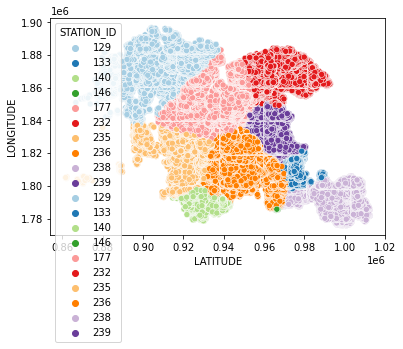

In [ ]:
chungnam_b, chungnam_s, chungnam_r = run('chungnam')

In [ ]:
name_string = 'chungnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (958741.056958825 1852399.37129964),0,0,0,91,-1,-1,-1,-1,J00091,S,"44,131.78080","21,600.14460","1,250.86180","85,305.18603","958,741.05696","1,852,399.37130",232
1,1,POINT (959569.475852156 1851040.60422561),0,0,0,93,-1,-1,-1,-1,J00093,C,"43,912.42966","21,482.21902","1,404.50203","83,721.80617","959,569.47585","1,851,040.60423",232
2,2,POINT (959723.355820146 1851874.47992336),0,0,0,93,-1,-1,-1,-1,J00093,C,"44,340.30992","21,539.78454","1,665.07686","84,293.45977","959,723.35582","1,851,874.47992",232


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (949171.0338 1854588.8172),10984873,4103,4610000,"193,838.00000","454,382.00000",20180226,4481031000,1,...,10,J12111,NPD-24C,"36,666.01726","20,978.92758","2,317.26264","93,059.40136","949,171.03380","1,854,588.81720",177
1,1,POINT (949152.4673 1854478.9531),10984874,4103,4610000,"193,820.00000","454,272.00000",20180226,4481031000,1,...,10,J12377,NMM-24C,"36,611.74319","20,952.63582","2,359.99088","92,988.91182","949,152.46730","1,854,478.95310",177
2,2,POINT (949155.4558 1854476.9382),10984875,4103,4610000,"193,823.00000","454,270.00000",20180226,4481031000,1,...,10,J12377,NMM-24C,"36,611.68971","20,951.99198","2,363.59630","92,985.42590","949,155.45580","1,854,476.93820",177


# 대구

1
Pandas(Index=0, WKT='POINT (1090873.0353 1763801.0701)', OCCRR_NO=432126.0, DBHIS_CD=311.0, MNAGN_CD=3480000, ARA_XCRD=336070.54699096817, ARA_YCRD=364286.9429690547, NTN_SPOT='라마90876380', LGDNG_CD=2771025625.0, IFTTR_TPCD=2.0, EXMNN_OTST=20141107, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=0.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=2, KOFTR_GROU=30, DMCLS_CD=1.0, AGCLS_CD=3.0, DNST_CD='C', HEIGHT=18.0, LDMARK_STN='J12230', MAP_LABEL='NEB-13C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_27710', path='C:/Users/user/Downloads/대구 임상도/FRT001003_27710/TB_FGDI_FS_IM5000_27710.shp', _29='POINT (1090873.0353 1763801.0701)', InputID=432126.0, MEAN=15892.1713023102, STDDEV=5810.92523309355, MIN=4643.86580985393, MAX=23578.4233305985)
1090873.0353 1763801.0701
2
Pandas(Index=0, WKT='POINT (1097247.95075208 1764695.93752518)', STORUNST=1, FROR_CD=2, FRTP_CD=2, KOFTR_GROU=30, DMCLS_CD=2.0, AGCLS_CD=5.0, DNST_CD='C', HEIGHT=14.0, LDMARK_STN='J12230', MAP_LABEL='NEB-25C', ETC_P

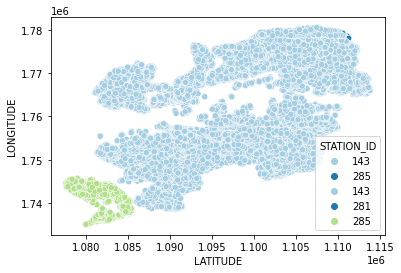

In [ ]:
daegu_b, daegu_s, daehu_r = run('daegu')

In [ ]:
name_string = 'daegu'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1097247.95075208 1764695.93752518),1,2,2,30,2,5,C,14,J12230,NEB-25C,"16,425.44066","4,684.49198","10,532.09917","27,744.33642","1,097,247.95075","1,764,695.93753",143
1,1,POINT (1102676.85356164 1777985.34267843),0,0,0,91,-1,-1,-1,-1,J00091,S,"25,988.13225","9,914.32447","2,418.04398","41,763.42794","1,102,676.85356","1,777,985.34268",143
2,2,POINT (1105326.08585424 1775059.00338251),0,0,0,91,-1,-1,-1,-1,J00091,S,"24,422.88480","10,056.76320","1,364.71405","40,887.39363","1,105,326.08585","1,775,059.00338",143


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (1090873.0353 1763801.0701),432126,311,3480000,"336,070.54699","364,286.94297",20141107,2771025625,1,...,18,J12230,NEB-13C,"15,892.17130","5,810.92523","4,643.86581","23,578.42333","1,090,873.03530","1,763,801.07010",143
1,1,POINT (1090881.2923 1763802.0015),432127,311,3480000,"336,078.80346","364,287.91703",20141107,2771025625,1,...,18,J12230,NEB-13C,"15,891.71375","5,807.82997","4,650.65732","23,582.95438","1,090,881.29230","1,763,802.00150",143
2,2,POINT (1090879.9321 1763800.2948),432128,311,3480000,"336,077.45130","364,286.20254",20141107,2771025625,1,...,18,J12230,NEB-13C,"15,891.11596","5,807.90324","4,650.28572","23,580.81860","1,090,879.93210","1,763,800.29480",143


# 광주

1
Pandas(Index=0, WKT='POINT (941896.0958 1676059.8036)', OCCRR_NO=1625497.0, DBHIS_CD=713.0, MNAGN_CD='4670000', ARA_XCRD=187474.0, ARA_YCRD=275753.0, NTN_SPOT='�ٶ�41897605', LGDNG_CD=2915512600, IFTTR_TPCD=2.0, EXMNN_OTST=20150921, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=0.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=3, KOFTR_GROU=77, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=12.0, LDMARK_STN='J12377', MAP_LABEL='NMM-24C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_29155', path='/home/koseyun/다운로드/광주/임상도/FRT001003_29155/TB_FGDI_FS_IM5000_29155.shp', _29='POINT (941896.0958 1676059.8036)', InputID=1625497.0, MEAN=17378.7856601745, STDDEV=5128.50576445476, MIN=3716.29556056375, MAX=21659.0757406958)
941896.0958 1676059.8036
2
Pandas(Index=0, WKT='POINT (948278.474457343 1676639.84244893)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=93, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00093', MAP_LABEL='C', ETC_PCMTT='2017�����ǵ�', layer='TB_F

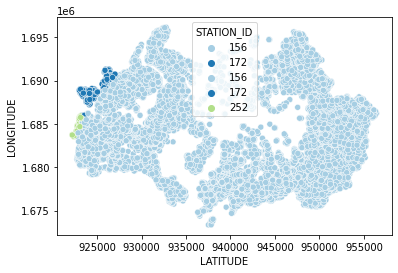

In [ ]:
local_string = 'gwangju'

gwangju_b, gwangju_s, gwangju_r = run(local_string)

In [ ]:
name_string = 'gwangju'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (948278.474457343 1676639.84244893),0,0,0,93,-1,-1,-1,-1,J00093,C,"20,959.11847","7,603.36830","2,663.99841","25,440.95525","948,278.47446","1,676,639.84245",156
1,1,POINT (950355.217587187 1675836.58629367),1,1,1,14,0,1,A,0,J11114,APR-01A,"22,962.61087","7,824.31858","4,804.86987","27,635.08034","950,355.21759","1,675,836.58629",156
2,2,POINT (950416.864241639 1676299.8790523),1,1,1,14,2,4,C,16,J11114,APR-24C,"22,812.11440","7,841.57493","4,816.65945","27,455.08675","950,416.86424","1,676,299.87905",156


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (941896.0958 1676059.8036),1625497,713,4670000,"187,474.00000","275,753.00000",20150921,2915512600,1,...,12,J12377,NMM-24C,"17,378.78566","5,128.50576","3,716.29556","21,659.07574","941,896.09580","1,676,059.80360",156
1,1,POINT (941900.8132 1676003.7995),1625516,713,4670000,"187,479.00000","275,697.00000",20150921,2915512600,1,...,8,J12377,NMM-24C,"17,410.22782","5,138.43174","3,717.85076","21,711.50540","941,900.81320","1,676,003.79950",156
2,2,POINT (941889.7872 1675997.8568),1625517,713,4670000,"187,468.00000","275,691.00000",20150921,2915512600,1,...,8,J12377,NMM-24C,"17,408.30369","5,132.91183","3,729.51249","21,712.02699","941,889.78720","1,675,997.85680",156


# 대전

1
Pandas(Index=0, WKT='POINT (982549.8331 1817300.3374)', OCCRR_NO=11718379.0, DBHIS_CD=5656.0, MNAGN_CD=3670000, ARA_XCRD=227423, ARA_YCRD=417253, NTN_SPOT='다바82541730', LGDNG_CD=3020011300, IFTTR_TPCD=2.0, EXMNN_OTST=20180402, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=1.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=2, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=81, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J20081', MAP_LABEL='N', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_30200', path='C:/Users/user/Downloads/대전임상도/FRT001003_30200/TB_FGDI_FS_IM5000_30200.shp', InputID=11718379.0, MEAN=14453.1512108972, STDDEV=4620.00910713072, MIN=3499.65537083354, MAX=21522.6043831007)
982549.8331 1817300.3374
2
Pandas(Index=0, WKT='POINT (995292.978070539 1810068.64366045)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, LOCAL_CD=30110, _14='POINT (995292.978070539 1810068.64366045)', Inp

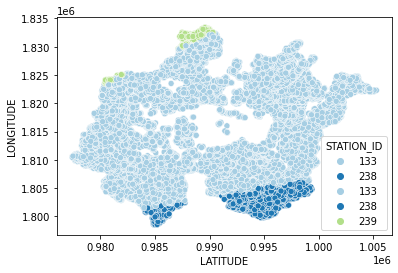

In [ ]:
local_string = 'daejeon'

data_b, data_s, data_bd, data_sd, data_r = loader(local_string)
print(1)
data_b = run_prob(data_b, local_string)
print(2)
data_s = run_prob(data_s, local_string)
print(3)
data_r = road_run_prob(data_r, local_string)
print(4)
data_b = apply_kmeans_station(kmeans, kmeans_label, data_b, local_string, 'bug_re')
print(5)
data_s = apply_kmeans_station(kmeans, kmeans_label, data_s, local_string, 'safe_re')
print(6)

col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
          'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
          'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_b[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
                'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
                'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
                'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)

for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass
    
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()

data.head(3)

data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_bug_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

wkt_col_list = ['WKT1', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
                'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
                'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)
data.columns = wkt_col_list


for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass

data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data = data.drop(['WKT1'], axis=1)
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_safe_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# 세종

In [ ]:
sejong_b, sejong_s, sejong_bd, sejong_sd, sejong_r = loader('sejong')

sejong_b_coord = extract_lat_log(sejong_b)

sejong_b['LATITUDE'] = sejong_b_coord[:, 0]
sejong_b['LONGITUDE'] = sejong_b_coord[:, 1]

sejong_s_coord = extract_lat_log(sejong_s)

sejong_s['LATITUDE'] = sejong_s_coord[:, 0]
sejong_s['LONGITUDE'] = sejong_s_coord[:, 1]

if 'STATION_ID' in sejong_b.columns:
  sejong_b = sejong_b.drop(['STATION_ID'], axis=1)

pred = sejong_b[['LATITUDE', 'LONGITUDE']]
pred_np = pred.to_numpy()

pred_lat = pred_np[:, 0]
pred_log = pred_np[:, 1]

pred_cls_label = kmeans.predict(pred_np)
pred_id = pd.DataFrame(data=[kmeans_label[row] for row in pred_cls_label], columns=['STATION_ID'])
sejong_b = pd.concat([sejong_b, pred_id], axis=1)

if 'STATION_ID' in sejong_s.columns:
  sejong_s = sejong_s.drop(['STATION_ID'], axis=1)

pred = sejong_s[['LATITUDE', 'LONGITUDE']]
pred_np = pred.to_numpy()

pred_lat = pred_np[:, 0]
pred_log = pred_np[:, 1]

pred_cls_label = kmeans.predict(pred_np)
pred_id = pd.DataFrame(data=[kmeans_label[row] for row in pred_cls_label], columns=['STATION_ID'])
sejong_s = pd.concat([sejong_s, pred_id], axis=1)


wkt_col_list = ['WKT1', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
              'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
              'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
              'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
            'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
            'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
            'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = sejong_b[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
                'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
                'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
                'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)

data.columns = wkt_col_list


for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass
      
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data = data.drop(['WKT1'], axis=1)
data.columns = col_list

with open(str(path / 'dbdata' / 'sejong_bug_db'), 'wb') as f:
  pickle.dump(sejong_b, f, pickle.HIGHEST_PROTOCOL)

wkt_col_list = ['WKT1', 'WKT', 'STORUNST1', 'STORUNST', 'FROR_CD1', 'FROR_CD', 'FRTP_CD1', 'FRTP_CD', \
                'KOFTR_GROU1', 'KOFTR_GROU', 'DMCLS_CD1', 'DMCLS_CD', 'AGCLS_CD1', 'AGCLS_CD', 'DNST_CD1', 'DNST_CD', \
                'HEIGHT1', 'HEIGHT', 'LDMARK_STN1', 'LDMARK_STN', 'MAP_LABEL1', 'MAP_LABEL' ,'MEAN' , \
                'STDDEV' ,'MIN' ,'MAX' ,'LATITUDE' ,'LONGITUDE', 'STATION_ID']

col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']


data = sejong_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)
data.columns = wkt_col_list

for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass

data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data = data.drop(['WKT1', 'STORUNST1', 'FROR_CD1', 'FRTP_CD1', 'KOFTR_GROU1', 'DMCLS_CD1', 'AGCLS_CD1', 'DNST_CD1', \
                  'HEIGHT1', 'LDMARK_STN1', 'MAP_LABEL1'], axis=1)
data.columns = col_list

with open(str(path / 'dbdata' / 'sejong_safe_db'), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


Pandas(Index=0, WKT='POINT (975464.6108 1853687.0191)', OCCRR_NO=5058588.0, DBHIS_CD=849.0, MNAGN_CD='1400467', ARA_XCRD=220146, ARA_YCRD=453617, NTN_SPOT='다바75465368', LGDNG_CD=3611038029, IFTTR_TPCD=2.0, EXMNN_OTST=20170210, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=2.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=1, FRTP_CD=1, KOFTR_GROU=12, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=20.0, LDMARK_STN='J11112', MAP_LABEL='APK-24C', ETC_PCMTT=nan, _27='POINT (975464.6108 1853687.0191)', InputID=5058588.0, MEAN=15144.6270492848, STDDEV=10308.9455873374, MIN=440.989696149234, MAX=29254.3812367187)
975464.6108 1853687.0191
Pandas(Index=0, WKT='MULTIPOINT ((982013.636290651 1826432.68647668))', _2='POINT (982013.636290651 1826432.68647668)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, STORUNST_2=0, FROR_CD_2=0, FRTP_CD_2=0, KOFTR_GROU_2=91, DMCLS_CD_2=nan, AGCLS_CD_2=na

# 서울

Pandas(Index=0, WKT='POINT (956126.2531 1958207.1286)', OCCRR_NO=425706.0, DBHIS_CD=116.0, MNAGN_CD=1400443, ARA_XCRD=200249.37019545623, ARA_YCRD=558074.154072996, NTN_SPOT='�ٻ�56125820', LGDNG_CD=1129013300, IFTTR_TPCD=2.0, EXMNN_OTST=20140616, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=0.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=3, KOFTR_GROU=77, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=12.0, LDMARK_STN='J12377', MAP_LABEL='NMM-24C', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_11290', path='/home/koseyun/다운로드/서울/임상도/FRT001003_11290/TB_FGDI_FS_IM5000_11290.shp')
956126.2531 1958207.1286
Pandas(Index=0, WKT='POINT (955390.670257081 1952734.50261635)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_11110', path='/home/koseyun/다운로드/서울/임상도/FRT001003_11110/TB_FGDI_FS_IM5000_11110.shp')
955390.670257081 1952734.50261635


,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (955390.670257081 1952734.50261635),0,0,0,91,-1,-1,-1,-1,J00091,S,"955,390.67026","1,952,734.50262",108
1,1,POINT (955198.240271037 1953057.56866279),0,0,0,91,-1,-1,-1,-1,J00091,S,"955,198.24027","1,953,057.56866",108
2,2,POINT (952416.571691649 1953510.89519096),0,0,0,91,-1,-1,-1,-1,J00091,S,"952,416.57169","1,953,510.89519",108


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,LGDNG_CD,EXMNN_OTST,STORUNST,...,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (956126.2531 1958207.1286),425706,116,1400443,"200,249.37020","558,074.15407",1129013300,20140616,1,...,77,2,4,C,12,J12377,NMM-24C,"956,126.25310","1,958,207.12860",108
1,1,POINT (956107.2607 1958207.23),425707,116,1400443,"200,230.37035","558,074.15435",1129013300,20140616,1,...,77,2,4,C,12,J12377,NMM-24C,"956,107.26070","1,958,207.23000",108
2,2,POINT (955874.1763 1958362.4182),425708,116,1400443,"199,996.37452","558,228.15649",1129013300,20140617,1,...,33,2,5,C,16,J12233,NQV-25C,"955,874.17630","1,958,362.41820",108


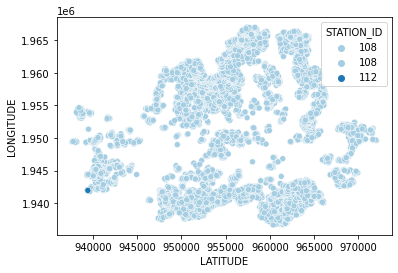

In [ ]:
local_string = 'seoul'

data_b = DataLoader(str(path / b_path / f'{local_string}_bug.csv')).data
data_s = DataLoader(str(path / s_path / f'{local_string}_safe.csv')).data

data_b_coord = extract_lat_log(data_b)
data_s_coord = extract_lat_log(data_s)

data_b['LATITUDE'] = data_b_coord[:, 0]
data_b['LONGITUDE'] = data_b_coord[:, 1]

data_s['LATITUDE'] = data_s_coord[:, 0]
data_s['LONGITUDE'] = data_s_coord[:, 1]

data_b = apply_kmeans_station(kmeans, kmeans_label, data_b, local_string, 'bug_re')
data_s = apply_kmeans_station(kmeans, kmeans_label, data_s, local_string, 'safe_re')

col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'LGDNG_CD',
            'EXMNN_OTST', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 
            'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_b[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'LGDNG_CD',
            'EXMNN_OTST', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 
            'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]
data = data.fillna(-1)

for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass
    
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_bug_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT',
            'LDMARK_STN', 'MAP_LABEL', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT',
            'LDMARK_STN', 'MAP_LABEL', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)
  
for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass

data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_safe_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


name_string = 'seoul'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

# 전북

1
Pandas(Index=0, WKT='POINT (941225.8159 1775704.5973)', OCCRR_NO=10983609.0, DBHIS_CD=4123.0, MNAGN_CD=1400471, ARA_XCRD=186298.0, ARA_YCRD=375429.0, NTN_SPOT='다마41227570', LGDNG_CD=4513033000, IFTTR_TPCD=2.0, EXMNN_OTST=20170616, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=2.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=11, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=12.0, LDMARK_STN='J12111', MAP_LABEL='NPD-24C', ETC_PCMTT='2017영상판독', layer='TB_FGDI_FS_IM5000_45130', path='C:/Users/user/Downloads/전북 암상도/FRT001003_45130/TB_FGDI_FS_IM5000_45130.shp', _29='POINT (941225.8159 1775704.5973)', InputID=10983609.0, MEAN=59294.4497336367, STDDEV=17581.2826224807, MIN=588.426037120138, MAX=95135.2062324023)
941225.8159 1775704.5973
2
Pandas(Index=0, WKT='POINT (969362.028656791 1756331.61923513)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=91, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00091', MAP_LABEL='S', ETC_PCMTT=nan, LOCAL_CD=

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (969362.028656791 1756331.61923513),0,0,0,91,-1,-1,-1,-1,J00091,S,"38,045.30595","13,380.36765","7,901.88488","73,069.29989","969,362.02866","1,756,331.61924",146
1,1,POINT (969980.700814687 1757089.23484297),0,0,0,91,-1,-1,-1,-1,J00091,S,"38,138.79359","13,473.94378","7,842.18002","74,006.27700","969,980.70081","1,757,089.23484",146
2,2,POINT (969815.993488578 1757556.9478706),0,0,0,91,-1,-1,-1,-1,J00091,S,"38,330.56524","13,529.54996","8,083.00041","74,133.88583","969,815.99349","1,757,556.94787",146


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (941225.8159 1775704.5973),10983609,4123,1400471,"186,298.00000","375,429.00000",20170616,4513033000,1,...,12,J12111,NPD-24C,"59,294.44973","17,581.28262",588.42604,"95,135.20623","941,225.81590","1,775,704.59730",140
1,1,POINT (940210.202 1779609.4564),10983613,4123,1400471,"185,262.00000","379,330.00000",20170802,4513038000,1,...,-1,J12111,NPD-25C,"62,015.88747","18,053.66238",497.93466,"98,515.44466","940,210.20200","1,779,609.45640",140
2,2,POINT (941562.8545 1775539.926),10983614,4123,1400471,"186,636.00000","375,266.00000",20170804,4513033000,1,...,0,J11117,ACP-01A,"59,007.50802","17,528.90289",224.57119,"94,773.82959","941,562.85450","1,775,539.92600",140


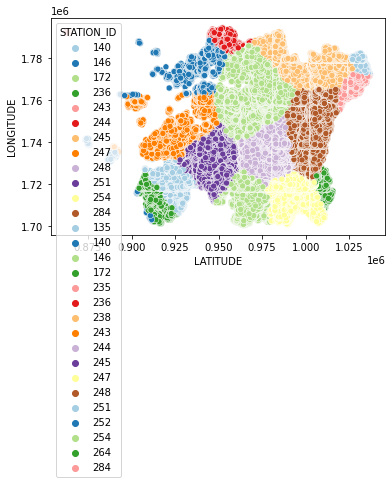

In [ ]:
jeonbuk_b, jeonbuk_s, jeonbuk_r = run('jeonbuk')

name_string = 'jeonbuk'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

#전남

1
Pandas(Index=0, WKT='POINT (982549.8331 1817300.3374)', OCCRR_NO=11718379.0, DBHIS_CD=5656.0, MNAGN_CD=3670000, ARA_XCRD=227423, ARA_YCRD=417253, NTN_SPOT='�ٹ�82541730', LGDNG_CD=3020011300, IFTTR_TPCD=2.0, EXMNN_OTST=20180402, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=1.0, LAST_UPUSR=nan, LAST_UPDT=nan, STORUNST=2, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=81, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J20081', MAP_LABEL='N', ETC_PCMTT=nan, layer='TB_FGDI_FS_IM5000_30200', path='/home/koseyun/다운로드/대전/임상도/FRT001003_30200/TB_FGDI_FS_IM5000_30200.shp', _29='POINT (982549.8331 1817300.3374)', InputID=11718379.0, MEAN=14453.1512108971, STDDEV=4620.0091071308, MIN=3499.65537083178, MAX=21522.6043831007)
982549.8331 1817300.3374
2
Pandas(Index=0, WKT='POINT (891575.349946631 1644940.32382451)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GROU=93, DMCLS_CD=nan, AGCLS_CD=nan, DNST_CD=nan, HEIGHT=nan, LDMARK_STN='J00093', MAP_LABEL='C', ETC_PCMTT=nan, LOCAL_CD=46110, _14='POINT (8710

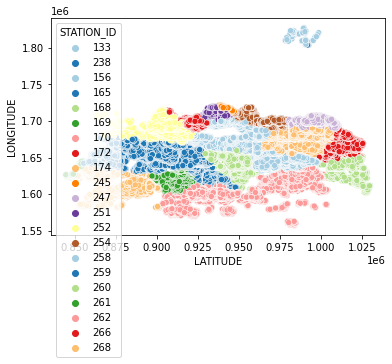

In [ ]:
jeonnam_b, jeonnam_s, jeonnam_r = run('jeonnam')

In [ ]:
name_string = 'jeonnam'

name_safe = name_string + '_safe_db'
name_bug = name_string + '_bug_db'

name_safe_mode = name_string + '_model.pickle'

name_prob = name_string + '_safe_db_prob'

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

with open(str(path / 'dbdata' / name_safe), 'rb') as f:
  data_safe = pickle.load(f)

with open(str(path / 'dbdata' / name_bug), 'rb') as f:
  data_bug = pickle.load(f)

display(data_safe.head(3))
print('')
display(data_bug.head(3))

,SEED,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (871028.425436457 1674179.46635406),0,0,0,93,-1,-1,-1,-1,J00093,C,"86,694.37866","30,073.53138",0.00000,"162,072.23557","891,575.34995","1,644,940.32382",165
1,1,POINT (871245.360681741 1674094.72346328),0,0,0,93,-1,-1,-1,-1,J00093,C,"86,492.52600","30,044.98444",0.00000,"161,839.67176","890,951.69482","1,642,284.60278",165
2,2,POINT (925686.71380503 1597752.46703109),0,0,0,93,-1,-1,-1,-1,J00093,C,"67,120.14497","27,594.52350",0.00000,"129,480.53626","891,144.49833","1,642,583.62081",165


,SEED,WKT,OCCRR_NO,DBHIS_CD,MNAGN_CD,ARA_XCRD,ARA_YCRD,EXMNN_OTST,LGDNG_CD,STORUNST,...,HEIGHT,LDMARK_STN,MAP_LABEL,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE,STATION_ID
0,0,POINT (958355.4052 1709409.8313),2132383,332,5380000,"203,771.24023","309,197.82142",20141222,4671037025,1,...,18,J12377,NMM-25C,"71,390.75146","29,171.14345","1,154.42679","149,705.40483","958,355.40520","1,709,409.83130",254
1,1,POINT (959548.3197 1709724.8605),17012128,1001,4770000,"204,963.00000","309,519.00000",20190531,4577035025,1,...,14,J12111,NPD-24C,"71,809.80912","29,324.55540",41.55504,"150,685.12977","959,548.31970","1,709,724.86050",254
2,2,POINT (959546.3357 1709727.8694),17012129,1001,4770000,"204,961.00000","309,522.00000",20190531,4577035025,1,...,14,J12111,NPD-24C,"71,811.95269","29,324.58190",43.50852,"150,686.28648","959,546.33570","1,709,727.86940",254


#제주

931986.0976 1493221.1369
5
6


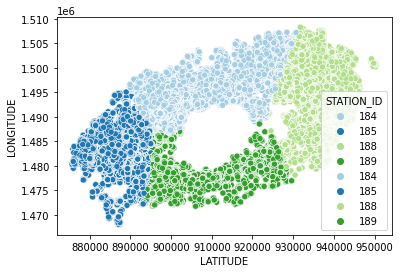

In [ ]:
local_string = 'jeju'

data_b = DataLoader(str(path / b_path / f'{local_string}_bug.csv')).data
data_s = DataLoader(str(path / s_path / f'{local_string}_safe.csv')).data

data_bd = DataLoader(str(path / bd_path / f'{local_string}_bug_distance.csv')).data
data_r = DataLoader(str(path / r_path / f'{local_string}_road_center.csv')).data

data_b = pd.concat([data_b, data_bd], axis=1)

p = re.compile(r'[a-zA-Z(())]')

lat_log = []
cnt = 0
for row in data_b.itertuples():

  try:
    lat, log = map(float, re.sub(p, '', row[28]).strip().split(' '))
    if cnt == 0:
      print(lat, log)

    lat_log.append([lat, log])
  
  except:
    print(row)
    pass

  cnt += 1

data_safe_coord = np.array(lat_log)

data_b['LATITUDE'] = data_safe_coord[:, 0]
data_b['LONGITUDE'] = data_safe_coord[:, 1]

#데이터 저장하는 구간
data_b.to_csv(str(path / 'safe' / f'{local_string}_safe.csv'.split('/')[-1]), index=False)

data_b = apply_kmeans_station(kmeans, kmeans_label, data_b, local_string, 'bug_re')
print(5)
data_s = apply_kmeans_station(kmeans, kmeans_label, data_s, local_string, 'safe_re')
print(6)


col_list = ['SEED', 'WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
          'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
          'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_b[['WKT', 'OCCRR_NO', 'DBHIS_CD', 'MNAGN_CD', 'ARA_XCRD', 'ARA_YCRD', 'EXMNN_OTST', \
                'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', \
                'DMCLS_CD', 'AGCLS_CD', 'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
                'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)

for c in ['OCCRR_NO', 'DBHIS_CD', 'EXMNN_OTST', 'LGDNG_CD', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass
    
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()
data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_bug_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

col_list = ['SEED', 'WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL',  \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']

data = data_s[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', \
          'DNST_CD', 'HEIGHT', 'LDMARK_STN', 'MAP_LABEL', \
          'MEAN', 'STDDEV', 'MIN', 'MAX', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]

data = data.fillna(-1)

for c in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'DMCLS_CD', 'AGCLS_CD', 'HEIGHT', 'STATION_ID']:
  try:
    data[c] = data[c].astype(int)
  except:
    print(c)
    pass

data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.reset_index(drop=True)
data = data.reset_index()

data.columns = col_list

with open(str(path / 'dbdata' / str(local_string + '_safe_db')), 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


# 경북

1
Pandas(Index=0, WKT='MULTIPOINT ((1089710.8343 1766682.599))', OCCRR_NO=10004836.0, DBHIS_CD=3141.0, MNAGN_CD=5220000, ARA_XCRD=334893.0, ARA_YCRD=367164.0, NTN_SPOT='라마89716668', LGDNG_CD=4785031047, IFTTR_TPCD=1.0, EXMNN_OTST=20170214, FRST_RGTER=nan, FRST_RGSTN=nan, OCCRR_SEQ=379.0, LAST_UPUSR=nan, LAST_UPDT=nan, layer='TB_DPMS_PWLDS_OCCRR_M_47-1', path='C:/Users/user/Downloads/경북 버그/FRT000202_47/TB_DPMS_PWLDS_OCCRR_M_47-1.shp', STORUNST=1, FROR_CD=2, FRTP_CD=1, KOFTR_GROU=11, DMCLS_CD=2.0, AGCLS_CD=4.0, DNST_CD='C', HEIGHT=14.0, LDMARK_STN='J12111', MAP_LABEL='NPD-24C', ETC_PCMTT=nan, layer_2='TB_FGDI_FS_IM5000_47850', path_2='C:/Users/user/Downloads/경북 임상도/FRT001003_47850/TB_FGDI_FS_IM5000_47850.shp', _31='POINT (1089710.8343 1766682.599)', InputID=10004836.0, MEAN=77665.47913608, STDDEV=42313.1757414832, MIN=4878.6133369777, MAX=278333.024998968)
1089710.8343 1766682.599
2
Pandas(Index=0, WKT='POINT (1180016.50221542 1765769.3390783)', STORUNST=0, FROR_CD=0, FRTP_CD=0, KOFTR_GR

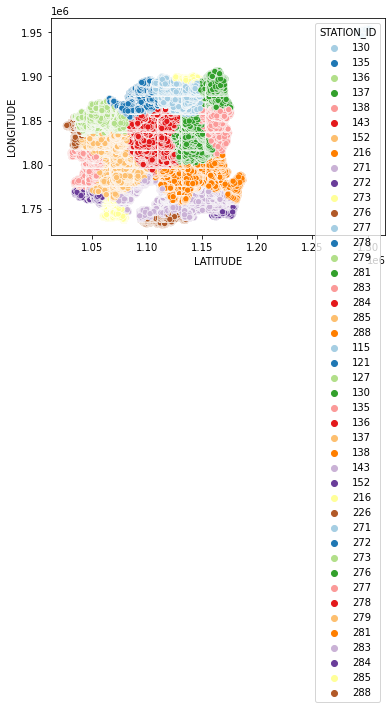

In [6]:
local_string = 'gyeongbuk'

data_b, data_s, data_r = run(local_string)